In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits

from pathlib import Path
from IPython.display import clear_output, display
import warnings
warnings.filterwarnings("ignore")

from imshows import imshow1, imshow2, imshow3


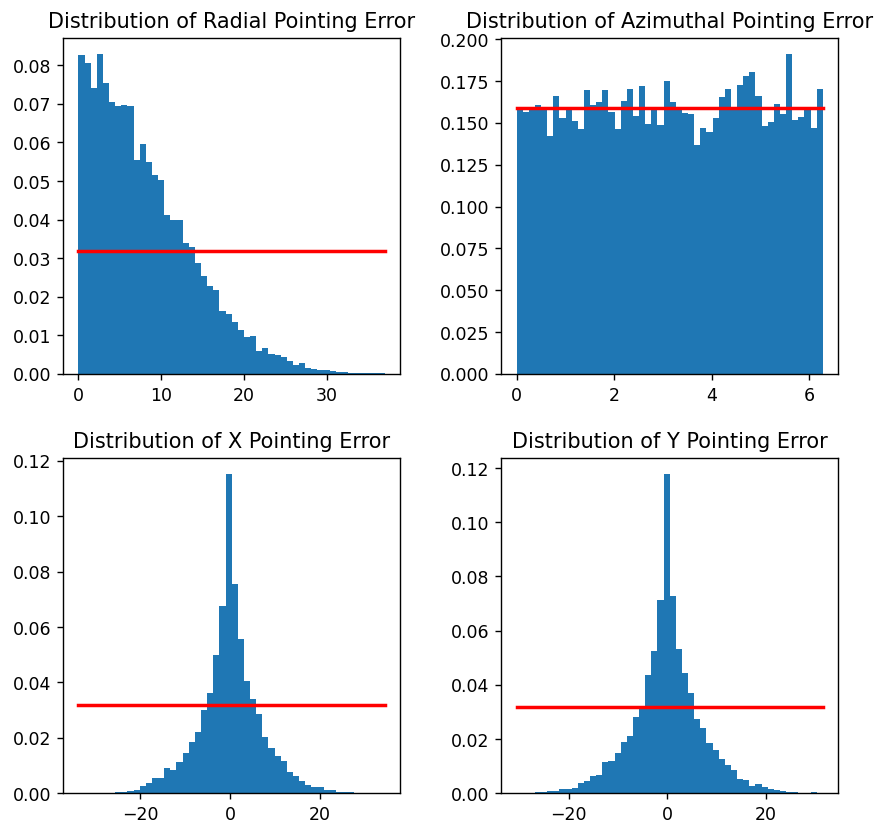

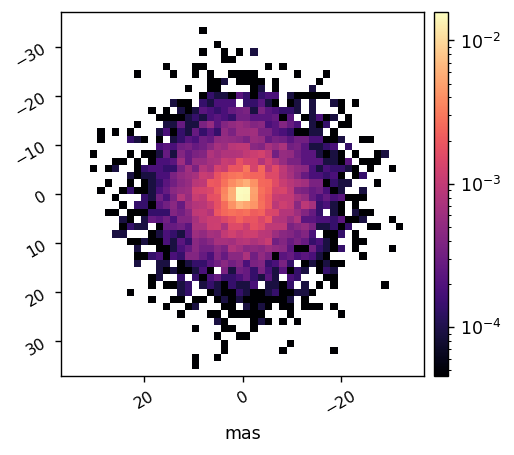

In [2]:
pointing_error = 10*u.mas # STD of pointing error
mean = 0

seed = 12

pointing_r = np.abs(np.random.default_rng(seed).normal(mean, pointing_error.to_value(u.mas), 10000))
pointing_th = np.random.default_rng(seed).uniform(low=0.0, high=2*np.pi, size=10000)

pointing_x = pointing_r*np.cos(pointing_th)
pointing_y = pointing_r*np.sin(pointing_th)

pointing = np.array([pointing_x, pointing_y]).T*u.mas

nbins = 50

fig = plt.figure(figsize=(8,8), dpi=125)

plt.subplot(221)
count, bins, ignored = plt.hist(pointing_r, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of Radial Pointing Error')

plt.subplot(222)
count, bins, ignored = plt.hist(pointing_th, nbins, density=True)
plt.plot(bins, 1/(2*np.pi)*np.ones_like(bins), linewidth=2, color='r')
plt.title('Distribution of Azimuthal Pointing Error')

plt.subplot(223)
count, bins, ignored = plt.hist(pointing_x, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of X Pointing Error')

plt.subplot(224)
count, bins, ignored = plt.hist(pointing_y, nbins, density=True)
plt.plot(bins, np.ones_like(bins)/(np.pi*pointing_error.to_value(u.mas)), linewidth=2, color='r')
plt.title('Distribution of Y Pointing Error')

plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.close()
display(fig)

rmax = np.max(pointing_r)
# fig = plt.figure()
h, xedges, yedges, im = plt.hist2d(pointing_x, pointing_y, bins=nbins, range=[[-rmax, rmax], [-rmax, rmax]], density=True)
plt.close()

imshow1(h, lognorm=True, pxscl=(xedges[0]-xedges[1]), xlabel='mas')


# get zemax shifts

In [3]:
import zosapi
from System import Enum,Int32,Double,Array
from pathlib import Path

zos_path = Path('C:/Users/Kian/Projects/apra-howfsc-fpgas/zemax_models/OFFAXIS_TMA.zos')
display(zos_path)

zos = zosapi.App()
ZOSAPI = zos.ZOSAPI
TheSystem = zos.TheSystem
TheSystem.LoadFile(str(zos_path),False)

wave = TheSystem.SystemData.Wavelengths.GetWavelength(1).Wavelength * 1e-6
display(wave)



WindowsPath('C:/Users/Kian/Projects/apra-howfsc-fpgas/zemax_models/OFFAXIS_TMA.zos')

Connected to OpticStudio at: c:\program files\ansys zemax opticstudio 2023 r1.00


7.5e-07

In [8]:
TheSystem.Close(False)
zos.TheApplication.PrimarySystem.Close(False)
zos.TheApplication.CloseApplication()


0.0

Ray Coordinates: [   0.         4030.15527516] [  0.         388.73133484] [  0.         285.00421099] [  0.         -38.10654925]


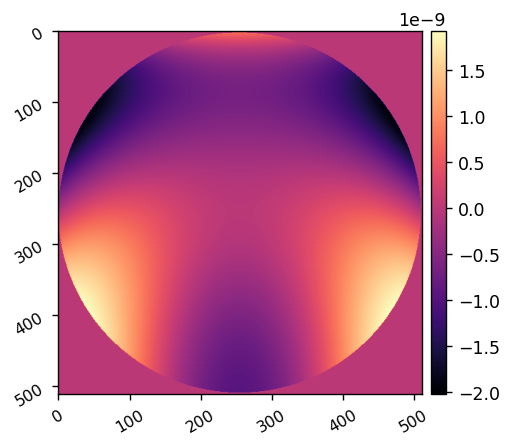

In [5]:
# surfaces we want the ray0 data at are 3, 4, 6, and 8
LDE = TheSystem.LDE

CB = LDE.GetSurfaceAt(3) # the coordinate break defining the system field bias
tilt_about_x = CB.GetCellAt(13)
tilt_about_y = CB.GetCellAt(14)
fb = np.float64(tilt_about_y.Value) # field bias

m1_ind = 4
m2_ind = 5
m3_ind = 7
m4_ind = 9

M1 = LDE.GetSurfaceAt(3)
M2 = LDE.GetSurfaceAt(4)
M3 = LDE.GetSurfaceAt(6)
M4 = LDE.GetSurfaceAt(8)

m1_m2 = M1.Thickness
display(m1_m2)

# apply pointing error by altering the field bias
tilt_about_x.set_Value(str(0))
tilt_about_y.set_Value(str(0))

Hx = 8.334999999999999E-002
Hy = 6.665000000000000E-002
H = np.sqrt(Hx**2 + Hy**2)

# get the real ray0 coordinates on each optic
MFE = TheSystem.MFE

m1_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m1_ind, 1, 0, 0, 0, 0, 0, 0)
m1_ray0 = np.array([m1_rx0,m1_ry0])

m2_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m2_ind, 1, 0, 0, 0, 0, 0, 0)
m2_ray0 = np.array([m2_rx0,m2_ry0])

m3_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m3_ind, 1, 0, 0, 0, 0, 0, 0)
m3_ray0 = np.array([m3_rx0,m3_ry0])

m4_rx0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_ry0 = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m4_ind, 1, 0, 0, 0, 0, 0, 0)
m4_ray0 = np.array([m4_rx0,m4_ry0])
print('Ray Coordinates:', m1_ray0, m2_ray0, m3_ray0, m4_ray0)

# Get the opd of the on-axis field
WFMap = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)
WFMapSettings = WFMap.GetSettings()
WFMapSettings.Sampling = ZOSAPI.Analysis.SampleSizes.S_1024x1024

WFMap.ApplyAndWaitForCompletion() # make sure the settings have been applied
WFMapResults = WFMap.GetResults() # get results

wfe = np.flip(np.array(WFMapResults.GetDataGrid(0).Values)) * wave
wfe[np.isnan(wfe)] = 0
imshow1(wfe)

In [6]:
p = pointing.to(u.degree).value
i = 2
display(p[i])

# apply pointing error by altering the field bias
# tilt_about_x.set_Value(str(p[i][0]))
# tilt_about_y.set_Value(str(p[i][1]))

hx = p[i][0]/H
hy = p[i][0]/H

# get the real ray coordinates on each optic
m1_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m1_ind, 1, hx, hy, 0, 0, 0, 0)
m1_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m1_ind, 1, hx, hy, 0, 0, 0, 0)
m1_ray = np.array([m1_rx,m1_ry])

m2_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m2_ind, 1, hx, hy, 0, 0, 0, 0)
m2_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m2_ind, 1, hx, hy, 0, 0, 0, 0)
m2_ray = np.array([m2_rx,m2_ry])

m3_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m3_ind, 1, hx, hy, 0, 0, 0, 0)
m3_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m3_ind, 1, hx, hy, 0, 0, 0, 0)
m3_ray = np.array([m3_rx,m3_ry])

m4_rx = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, m4_ind, 1, hx, hy, 0, 0, 0, 0)
m4_ry = MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, m4_ind, 1, hx, hy, 0, 0, 0, 0)
m4_ray = np.array([m4_rx,m4_ry])
print('Ray Coordinates:', m1_ray, m2_ray, m3_ray, m4_ray)

m1_shift = m1_ray0 - m1_ray
m2_shift = m2_ray0 - m2_ray
m3_shift = m3_ray0 - m3_ray
m4_shift = m4_ray0 - m4_ray
print('Shifts:', m1_shift, m2_shift, m3_shift, m4_shift)

array([7.66496459e-07, 1.91205404e-06])

Ray Coordinates: [-2.97378738e-06  4.03015527e+03] [2.24952863e-04 3.88731560e+02] [2.73231722e-03 2.85006935e+02] [-3.82178728e-06 -3.81065608e+01]
Shifts: [2.97378738e-06 2.97321958e-06] [-0.00022495 -0.00022509] [-0.00273232 -0.00272446] [3.82178728e-06 1.15577952e-05]
